# MLOps Colloquium - AirBNB New User Bookings

This data set, from [a Kaggle competition](https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/overview) that AirBNB used for recruitment, contains demographic and summary data about a batch of new users, together with some data about their web sessions. The goal of the original exercise was to train a model that could predict which country a new user would make their very first booking in.

We, however, are going to assume this model already exists. Instead, we're going to focus on a very common operation in real-world ML workflows: resolving data issues that can affect the accuracy of the model.

In [15]:
YOUR_NAME = 'Jizhu Li'
GCP_PROJECT_ID = '1008887000'
REGION = 'us-central1'
GCS_BUCKET = 'gs://rotman-vertex-demo'

In [2]:
!pip install kfp==1.8.14 scikit-learn google-cloud-pipeline-components==1.0.24 matplotlib
!pip install pyspark
!wget https://github.com/GoogleCloudDataproc/hadoop-connectors/releases/download/v2.2.11/gcs-connector-hadoop3-2.2.11-shaded.jar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.3/304.3 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 3.6 MB/s eta 0:00:00
  Preparing meta

In [3]:
import kfp
from kfp.v2 import dsl, components
from google_cloud_pipeline_components.v1.dataproc import \
    DataprocPySparkBatchOp

In [4]:
TRAINING_DATA_URI = GCS_BUCKET + "/airbnb-new-user-bookings"

The shell commands below are going to download a local copy of the dataset from GCS. You can manually inspect it (once the cell has finished running) from the Files tab on the left (in Colab).

In [5]:
!gsutil cp spark_code.py {GCS_BUCKET}/code/{YOUR_NAME}/spark_code.py
!gsutil cp -r {GCS_BUCKET}/airbnb-new-user-bookings/ ./

CommandException: No URLs matched: spark_code.py
Copying gs://rotman-vertex-demo/airbnb-new-user-bookings/age_gender_bkts.csv...
Copying gs://rotman-vertex-demo/airbnb-new-user-bookings/countries.csv...
Copying gs://rotman-vertex-demo/airbnb-new-user-bookings/sessions.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://rotman-vertex-demo/airbnb-new-user-bookings/users.csv...
/ [4 files][632.6 MiB/632.6 MiB]                                                
Operation completed over 4 objects/632.6 MiB.                                    


In order to experiment with the data before committing it to a pipeline, we can use a local PySpark installation to grab and visualize the data.

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DateType, FloatType
import pyspark.sql.functions as F

In [7]:
spark = SparkSession.builder.getOrCreate()

Now we have a Spark session, we can load the CSVs we pulled above into a DataFrame and start exploring it.

In [8]:
users_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('./airbnb-new-user-bookings/users.csv')
users_df.show()

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|


In [9]:
sessions_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('./airbnb-new-user-bookings/sessions.csv')
sessions_df.show()

+----------+--------------------+-----------+--------------------+---------------+------------+
|   user_id|              action|action_type|       action_detail|    device_type|secs_elapsed|
+----------+--------------------+-----------+--------------------+---------------+------------+
|d1mm9tcy42|              lookup|       null|                null|Windows Desktop|       319.0|
|d1mm9tcy42|      search_results|      click| view_search_results|Windows Desktop|     67753.0|
|d1mm9tcy42|              lookup|       null|                null|Windows Desktop|       301.0|
|d1mm9tcy42|      search_results|      click| view_search_results|Windows Desktop|     22141.0|
|d1mm9tcy42|              lookup|       null|                null|Windows Desktop|       435.0|
|d1mm9tcy42|      search_results|      click| view_search_results|Windows Desktop|      7703.0|
|d1mm9tcy42|              lookup|       null|                null|Windows Desktop|       115.0|
|d1mm9tcy42|         personalize|       

In the course of our exploration, we detect something... unusual... about the distribution of age columns.

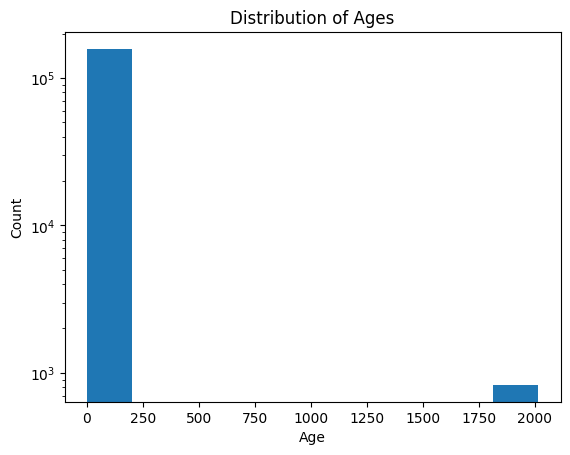

In [10]:
import matplotlib.pyplot as plt

ages = users_df.select(F.col('age').cast('int')).rdd.flatMap(lambda x: x).collect()
plt.hist([age for age in ages if age is not None])
plt.yscale('log')
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

It seems like there's some corruption somewhere in our data pipeline. Unless AirBNB really has a few ~2000-year-old customers, we need to figure out what these incorrect values mean and try to fix them.

In the cell below (with the `%%writefile` magic), write some Spark code that can pre-process the `users` table to deal with these erroneous fields.

Of course, feel free to create other exploratory cells above it to help you figure out how to investigate and solve the problem, but condense it all into the `%%writefile` cell once you're done, since our final Spark job needs to be a single, self-contained Spark application, not a bunch of Jupyter notebook cells.

In [13]:
# Assume the age above 120 is abnormal data entry. Check how many users' age are above 120
from pyspark.sql.functions import col

age_above_120 = users_df.filter(col("age") > 120).count()

print(f"Number of users with age above 120: {age_above_120}")

Number of users with age above 120: 830


In [14]:
# Calculate the abnormal age percentage amoung all the users and found that only 0.3% of the users with incorrect age value.
percentage = (age_above_120 / users_df.count()) * 100

print(f"Percentage of users with age above 120: {percentage:.2f}%")

Percentage of users with age above 120: 0.30%


To deal with this issue, one simple way is to replace the age over 120 with None to indicate missing data. Only 0.3% of missing data is acceptble to conduct further analysis.

Another way is to replace those incorrect values with the mean of the normal age range (0-120). Below is the solution.

In [18]:
%%writefile spark_code.py

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when

spark = SparkSession.builder.getOrCreate()

def main():

    train_data_path = './airbnb-new-user-bookings/users.csv'
    updated_data = './airbnb-new-user-bookings/updated_users.csv'

    # Read the users data
    users_df = spark.read \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .csv(train_data_path)

    # Calculate the mean age for normal age range (0 to 120)
    normal_age_users = users_df.filter((col("age") >= 0) & (col("age") <= 120))

    # Write the cleaned users data back to parquet
    normal_age_users.write.mode("overwrite").csv(str(updated_data), header=True)

    spark.stop()

if __name__ == "__main__":
    main()

Overwriting spark_code.py


# Putting it all together

Now that you've identified and solved the data issue, we need to make sure this fix can be applied automatically to all future training and evaulation runs. Below is the Kubeflow Pipeline we're using to train this model in production.

Given the pipeline below, modify it so that the data preprocessing Spark job you wrote above acts on the loaded data before it reaches the training job.

Hint: Try using the `DataprocPySparkBatchOp` component we imported above!

(You may find it useful to examine [this sample Notebook](https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/pipelines/google_cloud_pipeline_components_dataproc_tabular.ipynb) in detail to see some more examples of more sophisticated pipelines that make use of `DataprocPySparkBatchOp`)

In [21]:
@dsl.component(base_image="python:3.8-slim")
def build_args() -> list:
    return [
        "--train-data-path",
        TRAINING_DATA_URI
    ]

@dsl.component(base_image="python:3.8-slim")
def preprocess_data(args: list):
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import col, mean, when

    spark = SparkSession.builder.getOrCreate()
    
    train_data_arg = "--train-data-path"
    if train_data_arg in args:
      train_data_path = args[args.index(train_data_arg) + 1]
    updated_data = "preprocessed_data.csv"

    # Read the users data
    users_df = spark.read \
              .option("header", "true") \
              .option("inferSchema", "true") \
              .csv(train_data_path)

    # Calculate the mean age for normal age range (0 to 120)
    normal_age_users = users_df.filter((col("age") >= 0) & (col("age") <= 120))

    # Write the cleaned users data back to parquet
    normal_age_users.write.mode("overwrite").csv(str(updated_data), header=True)

    return updated_data

@dsl.pipeline(name='airbnb-pipeline', description='A pipeline that loads CSV files, preprocesses the data, and trains a model')
def airbnb_pipeline(
        model_output_path: str
):
    # Define the pipeline steps
    build_args_op = build_args()  

    # Define the preprocessing step
    preprocess_data_op = preprocess_data(build_args_op.output)  

    # Define the training step
    train_step = kfp.components.load_component_from_text("""
    name: Training
    description: This container runs a custom training routine.
    inputs:
    - name: trainingDataPath
      type: JsonArray
    outputs:
    - name: model
    implementation:
      container:
        image: rotman/training_image:v1
        command: ['python', 'train.py', {inputValue: trainingDataPath}, {outputPath: model}]
    """)
    train_op = train_step(preprocess_data_op.outputs)

    # Connect the preprocessing step to the training step
    train_op = train_op.after(preprocess_data_op)


You don't need to actually run this pipeline (although if you're feeling *very* adventurous you could; the easiest way to get access to a live Kubeflow instance would be on your own GCP account).

But let's at least compile the pipeline above into the `.json` file that would be submitted for execution. I can execute this JSON file to evaluate the solution!

Feel free to inspect the generated `pipeline.json` file on the "Files" tab on the left sidebar and see if you can get a feel for what it represents.

In [22]:
import kfp.v2.compiler as compiler
compiler.Compiler().compile(airbnb_pipeline, 'pipeline.json')
